In [1]:
library('SGL')
library('grpregOverlap')
library('MASS')
library('glmnet')
library('parallel')

Loading required package: Matrix
Loading required package: grpreg

Attaching package: ‘MASS’

The following object is masked from ‘package:grpregOverlap’:

    select

The following object is masked from ‘package:grpreg’:

    select

Loading required package: foreach
Loaded glmnet 2.0-16



In [2]:
df <- read.csv('/projects/leelab2/data/AD_DATA/simulatedData/latentData/df0.csv', header=TRUE)
df = as.data.frame(df)
numPheno <- 1
numGenes <- 2999
numSamples <- 500
numPaths <- 20

In [3]:
df_t = as.data.frame(t(df))
colnames(df_t) = c(paste('p', sep='', 1:numPheno), paste('g', sep='', 1:numGenes))
data_mat = df_t[1:numSamples, ]

In [4]:
bin_path_mat <- df[paste('pathway', 0:(numPaths-1), sep='')]
bin_path_mat <- bin_path_mat[-1, ]

In [5]:
group_index <- integer(numGenes) - 1
group_obj <- which(bin_path_mat == 1, arr.ind=T)
group_index[as.vector(group_obj[, 1])] <- as.vector(group_obj[, 2])

In [6]:
y <- data_mat$p1
x <- data.matrix(data_mat[, paste('g', sep='', 1:numGenes)])

In [7]:
head(x)

,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,⋯,g2990,g2991,g2992,g2993,g2994,g2995,g2996,g2997,g2998,g2999
X0,0.90378750,4.94927260,2.509696000,-0.7380382,-2.8428202,1.5988823,2.5764920,-0.7849524,3.7404761,-0.08895636,⋯,1.2338378,3.02199650,-0.59049314,0.78485674,-0.2819066,-2.1370814,-3.448518,0.7181603,-0.2944965,-3.339412500
X1,0.08057935,-0.07781644,0.558197000,-0.6558409,-2.3295600,1.2521298,-1.1082599,-0.9486393,-0.3081696,-1.56863030,⋯,-0.4627428,0.61619250,-0.47606972,-0.05841938,0.3072692,1.6511703,4.955984,-1.1770304,-2.2107100,0.003712148
X2,3.05009300,-5.80800340,1.662247000,1.5251266,-0.4307933,0.4878784,-0.5518155,-1.2150016,-3.8722043,2.29848430,⋯,0.5674718,-3.70858290,2.26604900,0.07283896,-1.1636672,1.0631675,-1.361657,0.8652222,1.4715338,-0.788489460
X3,0.25618672,-0.63430000,-0.001989812,-5.3139140,-3.2980275,2.9475412,-0.9283505,-1.8069029,1.5106225,1.93547930,⋯,-0.6009167,1.02343260,0.01151738,3.85393380,-1.0337965,-1.1797045,5.139686,0.2146778,-0.9214452,-3.691398100
X4,-1.06209170,2.77575060,-1.120023700,1.4179718,0.5674591,-1.4729061,2.7214885,1.8432969,2.4733315,-1.08108890,⋯,2.5037190,0.06231782,1.78544970,0.62754620,-0.9591803,-2.3527830,-2.062015,-4.1541340,2.6670900,-3.254387000
X5,-1.06973470,0.25288522,-1.926276600,0.7995334,-1.7876165,-0.5041668,2.0264773,0.3523512,-0.4164423,0.16083632,⋯,2.1026115,-3.56904360,0.89119720,-0.14293931,-0.3438913,-0.8105026,-2.464616,-2.4090330,-0.6562045,-0.501049160


In [8]:
dim(x)

[1]  500 2999

In [9]:
filtered_group_index <- group_index[group_index != -1]
filtered_x <- x[, which(group_index != -1)]

In [10]:
alphalist <- seq(0,1,by=0.1)
elasticnet <- lapply(alphalist, function(a){
  cv.glmnet(x, y, alpha=a)
})

In [11]:
elasticnet_df <- data.frame('lambda.min' = as.numeric(unlist(lapply(elasticnet, function(o) {o$lambda.min}))), 
                            'cvm' = as.numeric(unlist(lapply(elasticnet, function(o) {
                                o$cvm[o$lambda == o$lambda.min]}))),
                            'cvsd' = as.numeric(unlist(lapply(elasticnet, function(o) {
                                o$cvsd[o$lambda == o$lambda.min]}))),
                            'alpha' = alphalist)

In [12]:
elasticnet_df

lambda.min,cvm,cvsd,alpha
11.64369762,0.020560713,0.0015956437,0.0
0.20347692,0.004254699,0.0003877271,0.1
0.11165784,0.004228812,0.0004428322,0.2
0.07798301,0.004192652,0.0002672496,0.3
0.06127217,0.004230724,0.0002958080,0.4
0.04901773,0.004064097,0.0003348671,0.5
0.04084811,0.004026556,0.0004258229,0.6
0.03667982,0.004276162,0.0003272602,0.7
0.03209484,0.004279983,0.0003559258,0.8
0.02852875,0.004047531,0.0002629238,0.9


In [13]:
typeof(elasticnet_df$alpha)

[1] "double"

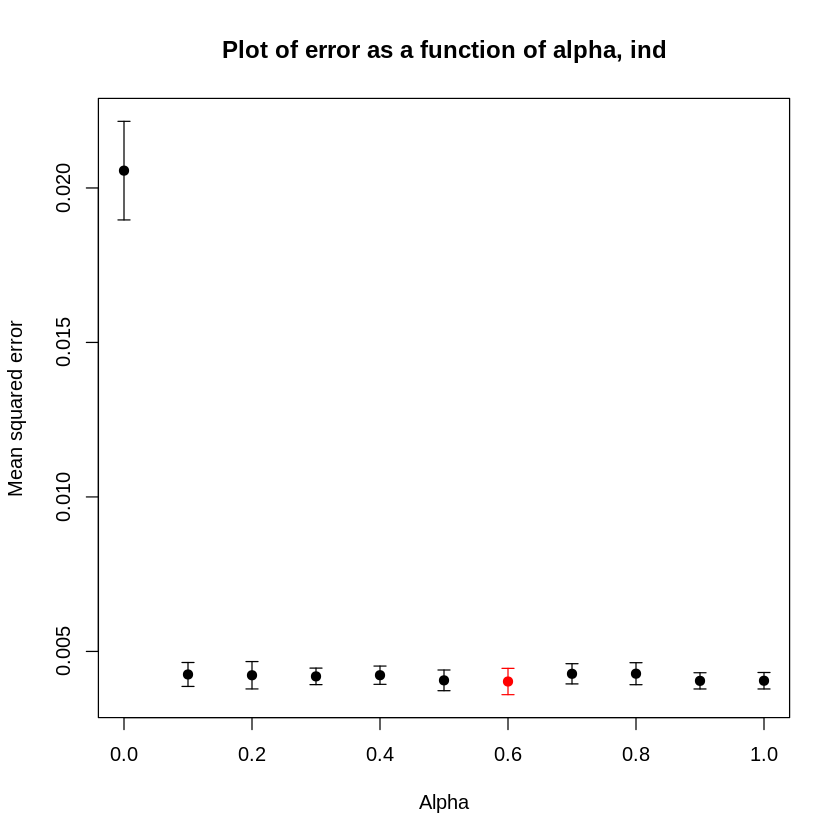

In [14]:
best_alpha <- elasticnet_df[elasticnet_df$cvm == min(elasticnet_df$cvm),]$alpha
best_lambda <- elasticnet_df[elasticnet_df$cvm == min(elasticnet_df$cvm),]$lambda.min
plot(elasticnet_df$alpha, elasticnet_df$cvm,
     ylim=range(c(elasticnet_df$cvm-elasticnet_df$cvsd, elasticnet_df$cvm+elasticnet_df$cvsd)),
     pch=19, xlab="Alpha", ylab="Mean squared error",
     main="Plot of error as a function of alpha, ind",
     col=ifelse(elasticnet_df$alpha==best_alpha, "red", "black")
    )
arrows(elasticnet_df$alpha, elasticnet_df$cvm-elasticnet_df$cvsd, 
       elasticnet_df$alpha, elasticnet_df$cvm+elasticnet_df$cvsd, 
       length=0.05, angle=90, code=3,
       col=ifelse(elasticnet_df$alpha==best_alpha, "red", "black"))

In [15]:
cat(sprintf('Elastic net: best alpha = %f, best lambda = %f', best_alpha, best_lambda))

Elastic net: best alpha = 0.600000, best lambda = 0.040848

In [ ]:
alphalist <- seq(0,1,by=0.1)
sparse_gl <- lapply(alphalist, function(a){
  cvSGL(data=list(x=filtered_x, y=y), index=filtered_group_index, type="linear", alpha=a)
})

In [ ]:
sparse_gl_df <- data.frame('lambda.min' = as.numeric(unlist(lapply(sparse_gl, function(o) {
                            o$lambdas[o$lldiff == min(o$lldiff)]}))), 
                            'nll' = as.numeric(unlist(lapply(sparse_gl, function(o) {
                                min(o$lldiff)}))),
                            'nllsd' = as.numeric(unlist(lapply(sparse_gl, function(o) {
                                o$llSD[o$lldiff == min(o$lldiff)]}))),
                            'alpha' = seq(0,1,by=0.1))
sparse_gl_df

In [ ]:
best_alpha_sgl <- sparse_gl_df[sparse_gl_df$nll == min(sparse_gl_df$nll),]$alpha
best_lambda_sgl <- sparse_gl_df[sparse_gl_df$nll == min(sparse_gl_df$nll),]$lambda.min
plot(sparse_gl_df$alpha, sparse_gl_df$nll,
     ylim=range(c(sparse_gl_df$nll-sparse_gl_df$nllsd, sparse_gl_df$nll+sparse_gl_df$nllsd)),
     pch=19, xlab="Alpha", ylab="Negative Log Likelihood",
     main="Plot of error as a function of alpha, ind",
     col=ifelse(sparse_gl_df$alpha==best_alpha_sgl, "red", "black")
    )
arrows(sparse_gl_df$alpha, sparse_gl_df$nll-sparse_gl_df$nllsd,
       sparse_gl_df$alpha, sparse_gl_df$nll+sparse_gl_df$nllsd, 
       length=0.05, angle=90, code=3,
       col=ifelse(sparse_gl_df$alpha==best_alpha_sgl, "red", "black"))

In [ ]:
cat(sprintf('Sparse Group Lasso: best alpha = %f, best lambda = %f', best_alpha_sgl, best_lambda_sgl))